本文借鉴[BigQuan案例](https://community.bigquant.com/t/%E9%87%8F%E5%8C%96%E5%AD%A6%E5%A0%82-%E7%AD%96%E7%95%A5%E5%BC%80%E5%8F%91%E4%BD%BF%E7%94%A8cvxopt%E5%8C%85%E5%AE%9E%E7%8E%B0%E9%A9%AC%E7%A7%91%E7%BB%B4%E8%8C%A8%E6%8A%95%E8%B5%84%E7%BB%84%E5%90%88%E4%BC%98%E5%8C%96%E4%BB%A5%E4%B8%80%E4%B8%AA%E8%82%A1%E7%A5%A8%E7%AD%96%E7%95%A5%E4%B8%BA%E4%BE%8B/274)，但使用斯坦福大学的`cvxpy`包求解。

# 模拟数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(123)

假设我们有4个资产，每个资产的收益率序列长度为1000，即1000个交易日.我们可以使用numpy.random.randn从正态分布中抽样。

In [2]:
## N资产数量
n_assets = 4

## 收益率长度
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

Text(0,0.5,'returns')

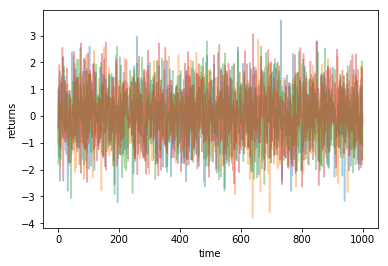

In [3]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

这些收益率序列可用于创建广泛的投资组合，这些投资组合都有不同的收益和风险（标准差）。 我们可以生成大量的随机权重向量并绘制这些投资组合。

一个权重向量对应一个投资组合。

In [4]:
# 产生随机权重的函数
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(n_assets))
print(rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


接下来，让我们评估这些随机投资组合将表现如何。 为了实现这一目标，我们计算收益率和波动率（这里我们使用标准差）。 这里，我们设置了一个过滤器，只允许绘制标准偏差<2的投资组合，以便更好地展示说明。

In [5]:
# 返回组合收益率和波动性
def random_portfolio(returns):

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # 过滤器
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

在代码中计算投资组合收益率的公式为：$$R = p^T w$$其中$R$是预期收益率，$p^T$是每个时间序列收益率所形成的列向量的转置，$w$是投资组合的权重向量。$p$是$N×1$列向量，所以$p^T$变成$1×N$行向量，其可以与$N×1$权重（列）向量$w$相乘以给出一个标量（数值）。

我们计算投资组合波动性的公式为:$$\sigma = \sqrt{w^T C w}$$，其中$C$是为$N×N$矩阵的协方差矩阵。在协方差矩阵中，对角线的值代表每个资产的波动性（方差），而其他位置的值代表了资产之间的协方差。

让我们产生500个随机投资组合，并输出每个组合的收益率和波动率

In [6]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

Text(0.5,1,'Mean and standard deviation of returns of randomly generated portfolios')

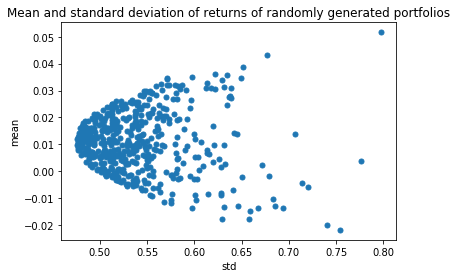

In [7]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std') # 标准差-波动性
plt.ylabel('mean') # 平均值-收益率
plt.title('Mean and standard deviation of returns of randomly generated portfolios') # 每个投资组合的收益率和波动性的散点图

这幅图是金融工程学里面可以说是最重要的一副图，横轴是波动率，纵轴是收益率。这个散点图中的每一个散点表示了一个投资组合（权重向量不一样），由于其形状类似子弹，所以又被称为子弹图。因为我们追求的组合有两个标准：相同的收益下，波动性最小；相同的波动性下，收益最高，因此越靠近左上角的资产组合其实是越优的，从下文可以看出，那是有效前沿。于是本文最重要的问题出来了，在给定多个资产历史数据的条件下，我们如何确定组合权重？这不得不引出马科维茨优化和有效前沿。

# 马科维茨优化和有效前沿

如何获取一个既定收益下风险（波动性）最低的投资组合？于是就转化成这样一个最优化问题：

优化问题描述：

目标函数(求风险最小值)：$$w^T C w$$

约束条件（既定收益且权重之和为1）：$$\sum_{i}{w_i} = 1$$$$R^T w = \mu$$
输出结果(返回一个权重向量)：$w$

In [ ]:
def trade_off curve(input_returns):
    n = len(input_returns)
    w = cvx.Variable(shape=(n, 1), nonneg=True)
    gamma = cvx.Parameter(nonneg=True)
    sigma = np.cov(returns)
    mus = input_returns.mean(axis=1)
    ret = mus.T * w
    risk = cvx.quad_form(w, sigma)
    # 杠杆为1，且不得有空头头寸
    constraints = [sum(w) == 1, w >= 0]
    prob = cvx.Problem(Maximize(ret - gamma * risk), constraints)
    
    # Compute trade-off curve.
    SAMPLES = 100
    risk_data = np.zeros(SAMPLES)
    ret_data = np.zeros(SAMPLES)
    gamma_vals = np.logspace(-2, 3, num=SAMPLES)
    for i in range(SAMPLES):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = sqrt(risk).value
        ret_data[i] = ret.value
    return ret_data, risk_data

NameError: name 'Sigma' is not defined

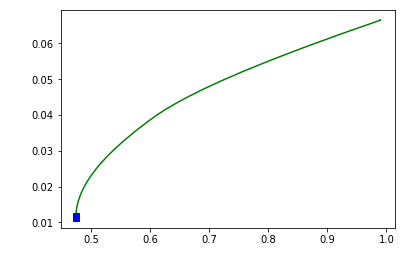

In [18]:
markers_on = [55, 75]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mus[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # 转化为cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # 约束条件
    G = -opt.matrix(np.eye(n))   # opt默认是求最大值，因此要求最小化问题，还得乘以一个负号
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # 使用凸优化计算有效前沿
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## 计算有效前沿的收益率和风险
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # 计算最优组合
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')